# REGRESSION GRADIENT BOOSTING 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import IPython
import IPython.display

In [3]:
from xgboost import XGBRegressor

In [4]:
def plot_results(y_train, y_train_pred, y_test, y_test_pred, figsize=[20,8]):
    df_result_train_plot = pd.DataFrame(np.vstack([y_train, y_train_pred]).T)
    df_result_train_plot.columns = ['train', 'train_pred']

    df_result_test_plot = pd.DataFrame(np.vstack([y_test, y_test_pred]).T)
    df_result_test_plot.columns = ['test', 'test_pred']
    
    fig, ax = plt.subplots(1, 2) #figsize=[50,16])
    df_result_train_plot.plot(style='.', figsize=figsize, ax=ax[0])
    df_result_test_plot.plot(style='.-', figsize=figsize, ax=ax[1])

def get_predictions(ds):
    list_y = []
    list_y_pred = []
    for x_batch, y_batch in iter(ds):        
      list_y.append(y_batch.numpy())
      list_y_pred.append(model.predict_on_batch(x_batch))
    return np.vstack(list_y), np.vstack(list_y_pred)     

def compute_metrics_regression(y, y_pred):
    mse = mean_squared_error(y, y_pred, squared=True) #mse
    rmse = mean_squared_error(y, y_pred, squared=False) #rmse    
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    # prevent infinite by cause of negativiy
    msle = None
    rmsle = None
    if (np.min(y) >=0)*(np.min(y_pred)>=0):
        msle = mean_squared_log_error(y, y_pred, squared=True) #msle    
        rmsle = mean_squared_log_error(y, y_pred, squared=False) #rmsle    
    #return {'mse':mse, 'rmse':rmse, 'mae':mae, 'mape':mape, 'msle':msle, 'rmsle':msle}
    return {'mse':mse, 'rmse':rmse, 'mae':mae}    


# 1. Datos para regression

## $$\{\pmb{x_i}, y_i\}_{i=1}^N~~;~~\pmb{x_i}\in R^D, y_i\in R$$

In [5]:
df_train, df_target = make_regression(
    n_samples = 1000,
    n_features=20, 
    n_informative=1,
    bias=0.5,        
    random_state=42,
    noise = 0.9, #10, #0.9,
    tail_strength = 0.7 #10 #0.7
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['feat_'+str(i) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)

num_outliers = 1000
num_examples = 1000
random_index = np.random.randint(0, num_examples, num_outliers)

array_sign = np.sign(np.random.rand(num_outliers)-0.5)
array_noise = np.int_(np.round(df_train.iloc[random_index,0]*np.random.rand(num_outliers)))
scaler = np.random.randint(5, 100, num_outliers)
# df_train.iloc[random_index,0] = array_sign*array_noise + scaler

print("data size: ", df_train.shape, df_target.shape)

data size:  (1000, 20) (1000, 1)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19
818,-0.005560,0.844774,-0.347302,-1.563034,0.419706,1.453275,-1.373403,1.435087,1.355573,-1.570881,0.519902,0.276582,1.868818,-0.078231,0.008556,-2.391956,1.178513,-1.179460,0.504483,-0.610858
443,0.504987,-0.114736,-0.707669,-1.519370,-0.653329,0.443819,-1.200296,1.266911,0.917862,-1.260884,-0.334501,1.765454,-0.474945,0.774634,0.404982,-0.792521,0.865755,-0.484234,1.032465,2.122156
156,-1.180626,0.339530,0.968745,-1.078364,0.963951,-0.224555,0.941256,-0.668149,-0.002686,0.042907,-0.589144,-1.049914,-0.494912,-1.058450,0.269235,0.328010,-1.044086,0.482665,-0.579855,-0.518436
849,-0.643872,0.401430,-0.703656,-1.506083,1.038386,0.642045,0.390193,-1.771057,0.169598,0.790349,1.124096,2.105856,-1.083597,0.505393,0.764158,-3.082562,1.111145,-0.417755,0.761192,-0.524669
519,-1.251199,0.871524,-1.210161,0.337482,-0.153998,1.591400,1.579438,-0.157025,0.132497,-0.883999,-0.611760,-0.161955,1.135948,0.876714,0.438413,0.143427,-1.532518,-0.263308,-1.320493,-0.381489
935,-0.204130,-2.274621,0.277553,-0.628149,-0.050801,-0.933106,-0.012044,-0.257052,1.687548,-1.039111,-1.120768,0.160650,-0.057397,-0.996932,0.662263,1.106710,3.117681,1.286382,0.726794,0.245114
954,1.882024,0.471468,0.073318,-1.012104,-0.125787,-1.289961,1.593187,0.823171,1.529550,-1.692465,-0.511216,0.055725,-0.989605,-1.295079,1.094192,-0.790474,1.345420,-1.654857,-0.426881,-0.158008
727,0.199380,1.968654,-2.441707,-0.803042,-1.178941,1.210066,-0.545726,-0.252880,0.816604,-0.833133,-0.183091,2.097127,-1.030122,-0.306381,0.302614,1.255226,-0.845628,1.654513,-1.096012,-1.178346
50,0.919872,0.185838,-1.134020,-1.190917,0.698816,-0.346772,-0.594211,-0.929136,1.466783,-0.241431,-0.616143,1.448820,-1.040199,-0.585793,-0.315082,0.113456,1.018923,0.678728,0.436236,0.505558
509,-0.165968,0.852441,0.491558,-0.595169,0.222378,0.504257,-0.431100,-1.086411,-0.666619,2.938188,0.777550,0.160611,-0.110400,-0.315192,-0.018167,0.731038,0.220145,-0.291406,0.694097,-0.675712


,target
235,0.805902
741,-3.278341
201,4.997714
676,-2.885230
354,-6.296241
353,1.544689
77,-1.638686
424,3.526760
298,11.176349
242,0.671857


Text(0, 0.5, 'target')

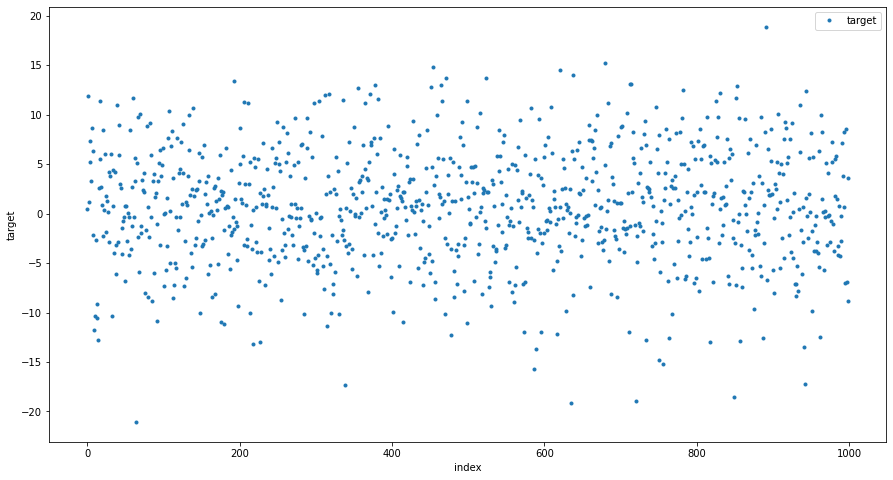

In [6]:
display(df_train.sample(10))
display(df_target.sample(10))

fig, ax = plt.subplots(1, 1)
figsize=(15, 8)
df_target.plot(style='.', figsize=figsize, ax=ax)
ax.set_xlabel('index')
ax.set_ylabel('target')

Text(0, 0.5, 'target')

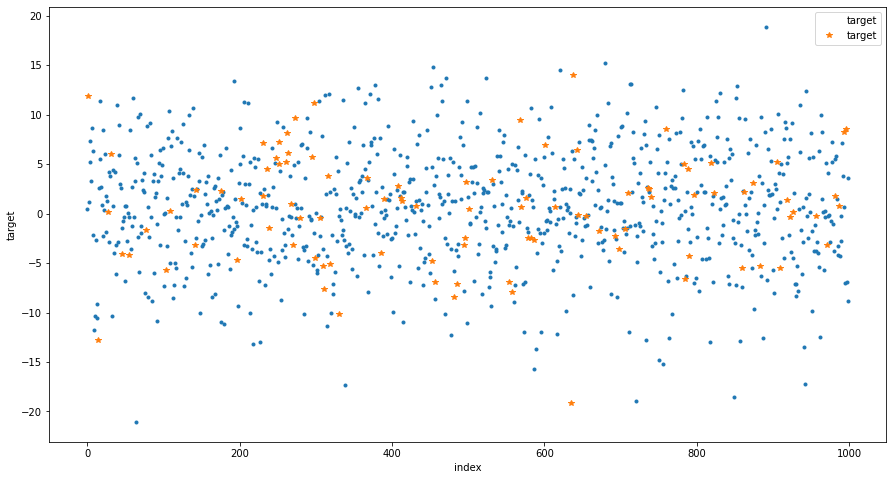

In [7]:
## Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

fig, ax = plt.subplots(1, 1)
figsize=(15, 8)
Y_train.plot(style='.', figsize=figsize, ax=ax)
Y_test.plot(style='*', figsize=figsize, ax=ax)
ax.set_xlabel('index')
ax.set_ylabel('target')

# 2. Preprocesamiento:  Feature scaling
* Remover la media (media=0) 
* Escalar la variance (var=1)

In [8]:
## Split training and test datasets.

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   

x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, Y_train, test_size=0.2, random_state=0)


# 2. Model

## Approximated function: 

## $$f(\pmb{x_i}, \pmb{\theta}) = \sum_{m=0}^M \beta_{m}b(\pmb{x_i};\{\gamma_j, R_j\}_{j=1}^J)$$

Donde $b(.)$ es un arbol de decision 
## $$b(\pmb{x_i};\{\gamma_j, R_j\}_{j=1}^J) = \sum_{j=1}^J \gamma_{j}I(\pmb{x_i} \in R_j)$$

# 3. Entrenamiento

## Loss function
$$L(y_i, f(\pmb{x_i}, \pmb{\theta})) = \frac{1}{2}(y_i - f(\pmb{x_i}, \pmb{\theta}))^2$$

## Learning
### Approximate the solution by Forward Stagewise Additive Modeling
1. Initialize $f_0(\pmb{x}) = 0$
2. For $m=1$ to $M$    
    * $\beta_{m}, \gamma_{m} = argmin_{\beta, \gamma}\sum_{i=1}^N L(y_i, f_{m-1}(\pmb{x_i}) + \beta b(\pmb{x_i};\gamma))$
    * $f_m(\pmb{x_i}) = f_{m-1}(\pmb{x_i}) + \beta_{m}b(\pmb{x_i};\gamma_{m})$
 


In [9]:
param_tmp = {'learning_rate':0.1, 
              'max_depth': 9,  
              'min_child_weight':6, 
              'subsample': 0.8, 
              'colsample_bytree': 0.8, 
              'reg_alpha': 0.1,
              'n_estimators': 300} 

model = XGBRegressor(learning_rate = param_tmp['learning_rate'], 
                         max_depth = param_tmp['max_depth'],
                         min_child_weight = param_tmp['min_child_weight'],
                         subsample = param_tmp['subsample'],
                         colsample_bytree = param_tmp['colsample_bytree'],
                         reg_alpha = param_tmp['reg_alpha'],
                         n_estimators = param_tmp['n_estimators']) 
    
eval_set = [(x_train, y_train), (x_val, y_val)]    
model.fit(x_train, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=20)

[17:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.2655	validation_1-rmse:5.21313
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4.77676	validation_1-rmse:4.74939
[2]	validation_0-rmse:4.33214	validation_1-rmse:4.31791
[3]	validation_0-rmse:3.94048	validation_1-rmse:3.94796
[4]	validation_0-rmse:3.80072	validation_1-rmse:3.91369
[5]	validation_0-rmse:3.67492	validation_1-rmse:3.91132
[6]	validation_0-rmse:3.34408	validation_1-rmse:3.59619
[7]	validation_0-rmse:3.04246	validation_1-rmse:3.3098
[8]	validation_0-rmse:2.9421	validation_1-rmse:3.3262
[9]	validation_0-rmse:2.68709	validation_1-rmse:3.08203
[10]	validation_0-rmse:2.61646	validation_1-rmse:3.0862
[11]	validation_0-rmse:2.38917	validation_1-rmse:2.87242
[12]	validation_0-rmse:2.18406	validation_1-r

XGBRegressor(colsample_bytree=0.8, max_depth=9, min_child_weight=6,
             n_estimators=300, reg_alpha=0.1, subsample=0.8)

# 4 Evaluacion 

In [10]:
y_train_predict = model.predict(X_train_scaled)
y_test_predict = model.predict(X_test_scaled)

In [11]:
dict_metrics_train = compute_metrics_regression(Y_train.values, y_train_predict)
dict_metrics_test = compute_metrics_regression(Y_test.values, y_test_predict)

df_results = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results.index = ['train', 'test'] 
df_results

,mse,rmse,mae
train,0.347078,0.589133,0.252938
test,1.558424,1.248368,0.995257


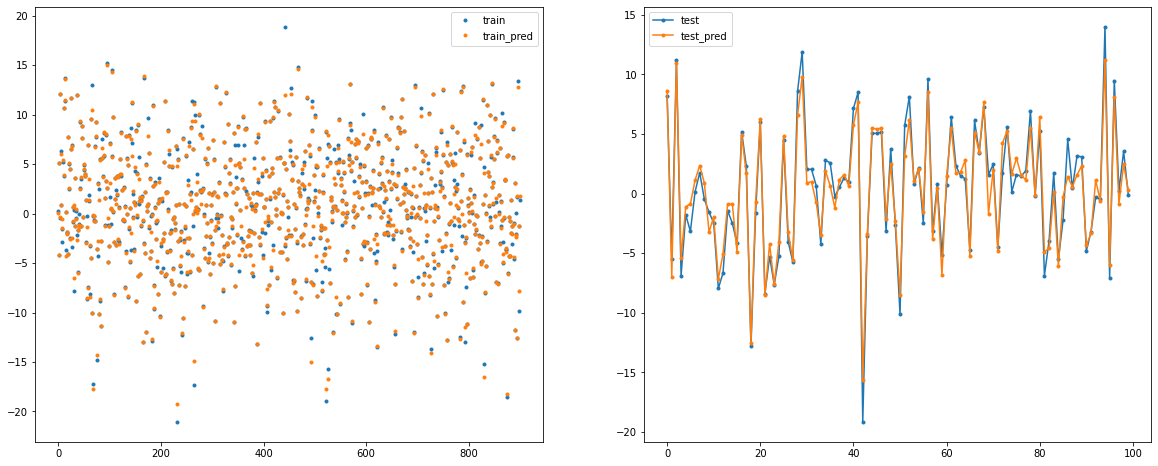

In [12]:
plot_results(Y_train.values.reshape(-1), y_train_predict.reshape(-1), Y_test.values.reshape(-1), y_test_predict.reshape(-1))